In [1]:
import pandas as pd
import pickle
pd.set_option("display.max_columns", None)
from collections import Counter
import spacy
import google_conf
import math
import matplotlib
import matplotlib.pyplot as plt
import json

In [2]:
mops_data = google_conf.setup(sheet_url="https://docs.google.com/spreadsheets/d/1VbCIAJssHKV9hlRTwzVFfm40CGnHesq53KXjv2qy4OM/edit?usp=sharing", service_account_path="../../../ServiceAccountsKey.json")

In [3]:
metadata_df = pd.read_json("../data/metadata_df.json")

In [4]:
metadata_df.columns

Index(['creator', 'datePublished', 'docType', 'doi', 'id', 'identifier',
       'isPartOf', 'issueNumber', 'keyphrase', 'language', 'outputFormat',
       'pageCount', 'pageEnd', 'pageStart', 'pagination', 'provider',
       'publicationYear', 'publisher', 'sequence', 'tdmCategory', 'title',
       'url', 'volumeNumber', 'wordCount', 'id_kase', 'docSubType',
       'sourceCategory', 'abstract', 'subTitle'],
      dtype='object')

In [5]:
columns_subset = ['creator', 'title', 'subTitle', 'publicationYear', 'docType', 'docSubType', 'doi', 'isPartOf', 'volumeNumber', 'issueNumber', 'keyphrase', 'language', 'pageCount', 'pageEnd', 'pageStart', 'pagination', 'provider', 'publisher','wordCount', 'abstract']
metadata_df[columns_subset].sample(10)

,creator,title,subTitle,publicationYear,docType,docSubType,doi,isPartOf,volumeNumber,issueNumber,keyphrase,language,pageCount,pageEnd,pageStart,pagination,provider,publisher,wordCount,abstract
1704,[George E. Howard],Review Article,None,1986,article,book-review,None,Journal of Biblical Literature,105,1,None,[eng],4,159,156,pp. 156-159,jstor,Society of Biblical Literature,2299,None
10977,[Adam Green],Cognitive Science and the Natural Knowledge of...,None,2013,article,article,10.5840/monist201396318,The Monist,96,3,"[natural knowledge, aquinas, calvin, cognitive...",[eng],21,419,399,399-419,portico,Philosophy Documentation Center,17980,None
16477,[Reverend Lawrence W. Althouse],Healing and Health in the Judaic-Christian Exp...,None,1985,article,None,10.1177/089801018500300106,Journal of Holistic Nursing,3,1,"[healing, church, healing ministry, florence n...",[eng],6,24,19,pp. 19-24,portico,SAGE Publications,4795,None
6782,[Thomas E. Phillips],untitled,None,2013,article,None,10.1111/rsr.12035_22,Religious Studies Review,39,2,"[phillips arapahoe, historical jesus, arapahoe...",[eng],9,113,113,113-113,portico,"John Wiley & Sons, Inc.",7965,None
859,[Julien M. Ogereau],A Survey of Κοινωνία and Its Cognates in Docum...,None,2015,article,research-article,None,Novum Testamentum,57,3,None,[eng],20,294,275,pp. 275-294,jstor,Brill,8896,This article consists of the summary of a comp...
4576,None,Religious Studies Review,None,2017,article,article,10.1111/rsr.12893,Religious Studies Review,43,1,None,[eng],3,87,85,85-87,portico,"John Wiley & Sons, Inc.",1357,None
15471,[A. T. Kraabel],Review Article,None,1981,article,book-review,None,The Biblical Archaeologist,44,4,None,[eng],1,254,254,p. 254,jstor,The American Schools of Oriental Research,801,None
14974,[JOSEPH A. FITZMYER],"Crucifixion in Ancient Palestine, Qumran Liter...",None,1978,article,research-article,None,The Catholic Biblical Quarterly,40,4,None,[eng],21,513,493,pp. 493-513,jstor,Catholic Biblical Association,10383,None
21337,[William Hart],Review Article,None,2004,article,book-review,None,New York History,85,4,None,[eng],3,403,401,pp. 401-403,jstor,New York State Historical Association,906,None
10573,[Robert Griffin],THE PRESENCE OF SAINT PAUL IN THE RELIGIOUS WO...,None,1965,article,research-article,None,Bibliothèque d'Humanisme et Renaissance,27,3,None,[eng],9,652,644,pp. 644-652,jstor,Librairie Droz,4799,None


In [6]:
25000 / 31832

0.7853732093490827

In [7]:
len(metadata_df[metadata_df["doi"].notnull()])

13100

In [8]:
journals = pd.DataFrame(metadata_df[metadata_df["doi"].notnull()].groupby("isPartOf").size().sort_values(ascending=False)).reset_index()
journals.columns = ["journal", "N_docs"]
journals[:10]

,journal,N_docs
0,Religious Studies Review,1726
1,Interpretation: A Journal of Bible and Theology,868
2,Expository Times,720
3,Review & Expositor: An International Baptist J...,717
4,The Heythrop Journal,686
5,New Testament Studies,412
6,Journal for the Study of the New Testament,360
7,Theological Studies,356
8,Reviews in Religion & Theology,330
9,Theology,325


In [9]:
metadata_df[metadata_df["doi"].notnull()].head(10)

,creator,datePublished,docType,doi,id,identifier,isPartOf,issueNumber,keyphrase,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sequence,tdmCategory,title,url,volumeNumber,wordCount,id_kase,docSubType,sourceCategory,abstract,subTitle
0,[Gerald F. Moede],1974-04-01,article,10.1111/j.1758-6623.1974.tb02427.x,ark://27927/phx7f872pd,"[{'name': 'doi', 'value': '10.1111/j.1758-6623...",The Ecumenical Review,2,"[church, church union, christian unity, confes...",[eng],"[unigram, bigram, trigram]",19,264,246,246-264,portico,1974,"John Wiley & Sons, Inc.",7.0,"[Philosophy - Applied philosophy, Political sc...",CHURCH UNION AS A MODEL OF CHRISTIAN UNITY,http://doi.org/10.1111/j.1758-6623.1974.tb02427.x,26,7827,0,None,None,None,None
1,[Ben C. Ollenburger],1987-10-01,article,10.1177/004057368704400307,ark://27927/phx6238nb98,"[{'name': 'doi', 'value': '10.1177/00405736870...",Theology Today,3,"[haarlem, miep gies, german, suffering, hollan...",[eng],"[unigram, bigram, trigram]",10,359,350,pp. 350-359,portico,1987,SAGE Publications,7.0,[Philosophy - Applied philosophy],Suffering and Hope: The Story Behind the Book,http://doi.org/10.1177/004057368704400307,44,5181,1,None,None,None,None
2,[Eric L. Johnson],1997-03-01,article,10.1177/009164719702500102,ark://27927/phz2f6c9d3v,"[{'name': 'doi', 'value': '10.1177/00916471970...",Journal of Psychology and Theology,1,"[kingdom, christian, creation, lordship, knowl...",[eng],"[unigram, bigram, trigram]",17,27,11,pp. 11-27,portico,1997,SAGE Publications,2.0,[Philosophy - Metaphysics],"Christ, the Lord of Psychology",http://doi.org/10.1177/009164719702500102,25,13697,2,None,None,None,None
3,"[Kimberly Matheson, Hymie Anisman, Renate Ysse...",2010-02-01,article,10.1177/1088868309349693,ark://27927/pgfvbkcxrg,"[{'name': 'doi', 'value': '10.1177/10888683093...",Personality and Social Psychology Review,1,"[religious, identity, religious identity, soci...",[eng],"[unigram, bigram, trigram]",12,71,60,60-71,portico,2010,SAGE Publications,6.0,"[Social sciences - Psychology, Social sciences...",Religiosity as Identity: Toward an Understandi...,http://doi.org/10.1177/1088868309349693,14,9915,3,None,None,None,None
4,[David J. Clark],1975-01-01,article,10.1177/026009357502600107,ark://27927/phx5181bbsv,"[{'name': 'doi', 'value': '10.1177/02600935750...",The Bible Translator (1950-2012),1,"[haenchen, overboard, barclay, apostles, went ...",[eng],"[unigram, bigram, trigram]",3,146,144,pp. 144-146,portico,1975,SAGE Publications,7.0,"[Linguistics - Grammar, Religion - Spiritual b...",What Went Overboard First?,http://doi.org/10.1177/026009357502600107,26,1652,4,None,None,None,None
5,[F. L. Shoemaker],1955-01-01,article,10.1111/j.1741-5446.1955.tb01287.x,ark://27927/phx29mqcsph,"[{'name': 'doi', 'value': '10.1111/j.1741-5446...",Educational Theory,1,"[idealism, universe, absolutes, metaphysical i...",[eng],"[unigram, bigram, trigram]",13,46,34,34-46,portico,1955,"John Wiley & Sons, Inc.",6.0,[Philosophy - Metaphysics],AN APPROACH TO METAPHYSICAL IDEALISTIC ECLECTI...,http://doi.org/10.1111/j.1741-5446.1955.tb01287.x,5,7605,5,None,None,None,None
6,[J. A. B. Holland],1961-09-01,article,10.1017/S0036930600003355,ark://27927/pgh1g2c67j2,"[{'name': 'local_publisher_id', 'value': 'S003...",Scottish Journal of Theology,3,"[irenaeus, adversus haereses, church, marcion,...",[eng],"[unigram, bigram, trigram]",6,317,312,312-317,portico,1961,Cambridge University Press,21.0,[History - Historical methodology],Review of Saint Irénée: Introduction à l'étude...,http://doi.org/10.1017/S0036930600003355,14,2848,6,None,None,None,None
7,[Jun Ki Chung],2010-07-01,article,10.1177/009182961003800302,ark://27927/phx5wv17ht2,"[{'name': 'doi', 'value': '10.1177/00918296100...",Missiology: An International Review,3,"[church, holy communion, korean, japanese, chr...",[eng],"[unigram, bigram, trigram]",17,269,253,pp. 253-269,portico,2010,SAGE Publications,2.0,[Religion - Spiritual belief systems],An

In [10]:
metadata_df["publicationYear"].mean()

1989.97008

# Journals...

In [11]:
journals_df = metadata_df.groupby("isPartOf").size().sort_values(ascending=False)
journals_df = journals_df.reset_index()
journals_df.rename(columns={0: "N"}, inplace=True)
journals_df.head(10)

,isPartOf,N
0,Religious Studies Review,1726
1,The Catholic Biblical Quarterly,893
2,Interpretation: A Journal of Bible and Theology,870
3,Journal of Biblical Literature,847
4,Expository Times,724
5,Review & Expositor: An International Baptist J...,719
6,The Heythrop Journal,686
7,The Journal of Theological Studies,492
8,New Testament Studies,412
9,Church History,379


In [12]:
journals_df_year_avr = metadata_df.groupby("isPartOf")["publicationYear"].mean().reset_index()
journals_df_year_avr.rename(columns={"publicationYear": "year_avr"}, inplace=True)

journals_df_year_min = metadata_df.groupby("isPartOf")["publicationYear"].min().reset_index()
journals_df_year_min.rename(columns={"publicationYear": "year_min"}, inplace=True)

journals_df_year_max = metadata_df.groupby("isPartOf")["publicationYear"].max().reset_index()
journals_df_year_max.rename(columns={"publicationYear": "year_max"}, inplace=True)

In [13]:
for df in [journals_df_year_avr, journals_df_year_min, journals_df_year_max]:
    journals_df = journals_df.merge(df, on="isPartOf")
journals_df.round(2).head(20)

,isPartOf,N,year_avr,year_min,year_max
0,Religious Studies Review,1726,2009.49,1976,2021
1,The Catholic Biblical Quarterly,893,1991.07,1939,2016
2,Interpretation: A Journal of Bible and Theology,870,1983.02,1947,2021
3,Journal of Biblical Literature,847,1982.76,1901,2021
4,Expository Times,724,1987.36,1938,2022
5,Review & Expositor: An International Baptist J...,719,1981.00,1932,2021
6,The Heythrop Journal,686,2012.38,1960,2021
7,The Journal of Theological Studies,492,1978.89,1900,2016
8,New Testament Studies,412,1988.89,1954,2021
9,Church History,379,1986.54,1934,2021


In [15]:
journals_df[:100]

,isPartOf,N,year_avr,year_min,year_max
0,Religious Studies Review,1726,2009.486674,1976,2021
1,The Catholic Biblical Quarterly,893,1991.070549,1939,2016
2,Interpretation: A Journal of Bible and Theology,870,1983.020690,1947,2021
3,Journal of Biblical Literature,847,1982.760331,1901,2021
4,Expository Times,724,1987.357735,1938,2022
...,...,...,...,...,...
95,Studies in World Christianity,35,2003.800000,1995,2017
96,Journal for the Study of the Old Testament,35,2006.142857,1978,2020
97,The Biblical Archaeologist,35,1969.971429,1939,1994
98,Anglican and Episcopal History,34,2005.705882,1988,2019


In [17]:
google_conf.set_with_dataframe(mops_data.add_worksheet("journals_100", 1,1), journals_df[:100])

In [34]:

journals_df["N"].sum()

25000

In [35]:
journals_df[:50]["N"].sum()

14808

In [102]:
journals_df["isPartOf"].tolist()[:20]

['Religious Studies Review',
 'The Catholic Biblical Quarterly',
 'Interpretation: A Journal of Bible and Theology',
 'Journal of Biblical Literature',
 'Expository Times',
 'Review & Expositor: An International Baptist Journal',
 'The Heythrop Journal',
 'The Journal of Theological Studies',
 'New Testament Studies',
 'Church History',
 'Journal for the Study of the New Testament',
 'Theological Studies',
 'Theology',
 'Reviews in Religion & Theology',
 'Theology Today',
 'Neotestamentica',
 'Scottish Journal of Theology',
 'The Journal of Religion',
 'Novum Testamentum',
 'Missiology: An International Review']

In [12]:
#google_conf.set_with_dataframe(mops_data.add_worksheet("jstor_journals_minmaxavryear", 1, 1), journals_df.reset_index())

#

In [13]:
metadata_df.shape

(25000, 29)

In [45]:
metadata_df["wordCount"].sum()

232665684

In [15]:
metadata_df

,creator,datePublished,docType,doi,id,identifier,isPartOf,issueNumber,keyphrase,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sequence,tdmCategory,title,url,volumeNumber,wordCount,id_kase,docSubType,sourceCategory,abstract,subTitle
0,[Gerald F. Moede],1974-04-01,article,10.1111/j.1758-6623.1974.tb02427.x,ark://27927/phx7f872pd,"[{'name': 'doi', 'value': '10.1111/j.1758-6623...",The Ecumenical Review,2,"[church, church union, christian unity, confes...",[eng],"[unigram, bigram, trigram]",19,264,246,246-264,portico,1974,"John Wiley & Sons, Inc.",7.0,"[Philosophy - Applied philosophy, Political sc...",CHURCH UNION AS A MODEL OF CHRISTIAN UNITY,http://doi.org/10.1111/j.1758-6623.1974.tb02427.x,26,7827,0,None,None,None,None
1,[Ben C. Ollenburger],1987-10-01,article,10.1177/004057368704400307,ark://27927/phx6238nb98,"[{'name': 'doi', 'value': '10.1177/00405736870...",Theology Today,3,"[haarlem, miep gies, german, suffering, hollan...",[eng],"[unigram, bigram, trigram]",10,359,350,pp. 350-359,portico,1987,SAGE Publications,7.0,[Philosophy - Applied philosophy],Suffering and Hope: The Story Behind the Book,http://doi.org/10.1177/004057368704400307,44,5181,1,None,None,None,None
2,[Eric L. Johnson],1997-03-01,article,10.1177/009164719702500102,ark://27927/phz2f6c9d3v,"[{'name': 'doi', 'value': '10.1177/00916471970...",Journal of Psychology and Theology,1,"[kingdom, christian, creation, lordship, knowl...",[eng],"[unigram, bigram, trigram]",17,27,11,pp. 11-27,portico,1997,SAGE Publications,2.0,[Philosophy - Metaphysics],"Christ, the Lord of Psychology",http://doi.org/10.1177/009164719702500102,25,13697,2,None,None,None,None
3,"[Kimberly Matheson, Hymie Anisman, Renate Ysse...",2010-02-01,article,10.1177/1088868309349693,ark://27927/pgfvbkcxrg,"[{'name': 'doi', 'value': '10.1177/10888683093...",Personality and Social Psychology Review,1,"[religious, identity, religious identity, soci...",[eng],"[unigram, bigram, trigram]",12,71,60,60-71,portico,2010,SAGE Publications,6.0,"[Social sciences - Psychology, Social sciences...",Religiosity as Identity: Toward an Understandi...,http://doi.org/10.1177/1088868309349693,14,9915,3,None,None,None,None
4,[David J. Clark],1975-01-01,article,10.1177/026009357502600107,ark://27927/phx5181bbsv,"[{'name': 'doi', 'value': '10.1177/02600935750...",The Bible Translator (1950-2012),1,"[haenchen, overboard, barclay, apostles, went ...",[eng],"[unigram, bigram, trigram]",3,146,144,pp. 144-146,portico,1975,SAGE Publications,7.0,"[Linguistics - Grammar, Religion - Spiritual b...",What Went Overboard First?,http://doi.org/10.1177/026009357502600107,26,1652,4,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,[Lightner Witmer],1922-07-01,article,None,http://www.jstor.org/stable/6258,"[{'name': 'issn', 'value': '00963771'}, {'name...",The Scientific Monthly,1,None,[eng],"[unigram, bigram, trigram, fullText]",11,67,57,pp. 57-67,jstor,1922,American Association for the Advancement of Sc...,NaN,[Philosophy - Applied philosophy],What Is Intelligence and Who Has It?,http://www.jstor.org/stable/6258,15,4982,24995,research-article,"[Biological Sciences, General Science, Science...",None,None
24996,[Phyllis E. -- (Phyllis Ethel) Wachter],2010-06-24,article,None,ark://27927/phw50sgnbv,"[{'name': 'local_publisher_id', 'value': 'S152...",Biography,4,"[autobiography, chter current, literary, writi...",[eng],"[unigram, bigram, trigram]",15,345,331,pp. 331-345,portico,2010,Project MUSE,5.0,[Arts - Literature],Bibliography of Works about Life-Writing for t...,None,10,6739,24996,None,None,None,None
24997,[J. K. Mozley],1933-07-01,article,None,http://www.jstor.org/stable/23955118,"[{'name': 'issn', 'value': '00225185'}, {'name...",The Journal of Theological Studies,135,None,[eng],"[unigram, bigram, trigram]",11,304,294,pp. 294-304,jstor,1933,Oxford University Press,NaN,[Religion - Spiritual b

In [46]:
mask_articles = metadata_df["docSubType"]=="research-article"

In [47]:
# but there is also a lot of empty
(metadata_df["docSubType"].isnull()).sum()

10711

In [48]:
metadata_df[metadata_df["docSubType"].isnull()]

,creator,datePublished,docType,doi,id,identifier,isPartOf,issueNumber,keyphrase,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sequence,tdmCategory,title,url,volumeNumber,wordCount,id_kase,docSubType,sourceCategory,abstract,subTitle
0,[Gerald F. Moede],1974-04-01,article,10.1111/j.1758-6623.1974.tb02427.x,ark://27927/phx7f872pd,"[{'name': 'doi', 'value': '10.1111/j.1758-6623...",The Ecumenical Review,2,"[church, church union, christian unity, confes...",[eng],"[unigram, bigram, trigram]",19,264,246,246-264,portico,1974,"John Wiley & Sons, Inc.",7.0,"[Philosophy - Applied philosophy, Political sc...",CHURCH UNION AS A MODEL OF CHRISTIAN UNITY,http://doi.org/10.1111/j.1758-6623.1974.tb02427.x,26,7827,0,None,None,None,None
1,[Ben C. Ollenburger],1987-10-01,article,10.1177/004057368704400307,ark://27927/phx6238nb98,"[{'name': 'doi', 'value': '10.1177/00405736870...",Theology Today,3,"[haarlem, miep gies, german, suffering, hollan...",[eng],"[unigram, bigram, trigram]",10,359,350,pp. 350-359,portico,1987,SAGE Publications,7.0,[Philosophy - Applied philosophy],Suffering and Hope: The Story Behind the Book,http://doi.org/10.1177/004057368704400307,44,5181,1,None,None,None,None
2,[Eric L. Johnson],1997-03-01,article,10.1177/009164719702500102,ark://27927/phz2f6c9d3v,"[{'name': 'doi', 'value': '10.1177/00916471970...",Journal of Psychology and Theology,1,"[kingdom, christian, creation, lordship, knowl...",[eng],"[unigram, bigram, trigram]",17,27,11,pp. 11-27,portico,1997,SAGE Publications,2.0,[Philosophy - Metaphysics],"Christ, the Lord of Psychology",http://doi.org/10.1177/009164719702500102,25,13697,2,None,None,None,None
3,"[Kimberly Matheson, Hymie Anisman, Renate Ysse...",2010-02-01,article,10.1177/1088868309349693,ark://27927/pgfvbkcxrg,"[{'name': 'doi', 'value': '10.1177/10888683093...",Personality and Social Psychology Review,1,"[religious, identity, religious identity, soci...",[eng],"[unigram, bigram, trigram]",12,71,60,60-71,portico,2010,SAGE Publications,6.0,"[Social sciences - Psychology, Social sciences...",Religiosity as Identity: Toward an Understandi...,http://doi.org/10.1177/1088868309349693,14,9915,3,None,None,None,None
4,[David J. Clark],1975-01-01,article,10.1177/026009357502600107,ark://27927/phx5181bbsv,"[{'name': 'doi', 'value': '10.1177/02600935750...",The Bible Translator (1950-2012),1,"[haenchen, overboard, barclay, apostles, went ...",[eng],"[unigram, bigram, trigram]",3,146,144,pp. 144-146,portico,1975,SAGE Publications,7.0,"[Linguistics - Grammar, Religion - Spiritual b...",What Went Overboard First?,http://doi.org/10.1177/026009357502600107,26,1652,4,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24965,[Douglas J. Moo],1986-01-01,article,10.1017/S0028688500013540,ark://27927/pgj9fc0k3z,"[{'name': 'local_publisher_id', 'value': 'S002...",New Testament Studies,1,"[romans, cranfield romans, israel, adamic view...",[eng],"[unigram, bigram, trigram]",14,135,122,122-135,portico,1986,Cambridge University Press,9.0,"[Religion - Theology, History - Historical met...",Israel and Paul in Romans 7.7–12,http://doi.org/10.1017/S0028688500013540,32,8470,24965,None,None,None,None
24970,[Barbara Ann Hedin],1996-01-01,article,10.1177/002096439605000108,ark://27927/phx61z5xbcv,"[{'name': 'doi', 'value': '10.1177/00209643960...",Interpretation: A Journal of Bible and Theology,1,"[spirit, passage, christ, verses, mortal bodie...",[eng],"[unigram, bigram, trigram]",4,58,55,pp. 55-58,portico,1996,SAGE Publications,8.0,"[History - Historical methodology, Philosophy ...",Romans 8:6–11,http://doi.org/10.1177/002096439605000108,50,2057,24970,None,None,None,None
24980,[],1988-09-01,article,10.1177/004056398804900333,ark://27927/phx615xwqs1,"[{'name': 'doi', 'value': '10.1177/00405639880...",Theological Studies,3,"[church, shorter notices, christology, theolog...",[eng],"[unigram, bigram, trigra

In [19]:
mask_articles.sum()

7666

In [20]:
metadata_df[mask_articles]["wordCount"].sum()

78667321

In [21]:
mask_doi = metadata_df["doi"].notnull()
len(metadata_df[mask_doi])

13100

In [50]:
metadata_df.groupby("provider").size()

provider
jstor      11205
portico    13795
dtype: int64

# Define year, decade, and bidecade

In [11]:
metadata_df["year"] = metadata_df["datePublished"].apply(lambda x: int(x.partition("-")[0]))

In [12]:
(metadata_df["year"] >= 1900).sum()

24997

In [13]:
metadata_df["year"].max()

2022

In [14]:
(metadata_df["year"].between(1900,2019)).sum()

24588

In [15]:
metadata_df[metadata_df["year"].between(1900,1909)]

,creator,datePublished,docType,doi,id,identifier,isPartOf,issueNumber,keyphrase,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sequence,tdmCategory,title,url,volumeNumber,wordCount,id_kase,docSubType,sourceCategory,abstract,subTitle,year
31,[Otto Pfleiderer],1907-01-01,article,10.5840/monist190717436,ark://27927/pgh2rhf8xx3,"[{'name': 'doi', 'value': '10.5840/monist19071...",The Monist,4,"[christianity, evolution, church, ecclesiastic...",[eng],"[unigram, bigram, trigram]",19,559,541,541-559,portico,1907,Philosophy Documentation Center,3.0,"[Philosophy - Metaphysics, History - Historica...",The Evolution of Christianity,http://doi.org/10.5840/monist190717436,17,6402,31,None,None,None,None,1907
148,"[H. A. A. Kennedy, William H. Ryder, W. C. Kei...",1907-07-01,article,None,http://www.jstor.org/stable/3154522,"[{'name': 'issn', 'value': '15503283'}, {'name...",The American Journal of Theology,3,None,[eng],"[unigram, bigram, trigram, fullText]",16,542,527,pp. 527-542,jstor,1907,University of Chicago Press,NaN,"[History - Historical methodology, Religion - ...",Recent Literature on the New Testament,http://www.jstor.org/stable/3154522,11,7198,148,book-review,"[Religion, Humanities]",None,None,1907
153,[John C. Rose],1906-11-01,article,10.2307/1944844,ark://27927/pgh1g0cbznp,"[{'name': 'local_publisher_id', 'value': 'S000...",American Political Science Review,1,"[constitution, suffrage, constitution art, fif...",[eng],"[unigram, bigram, trigram]",27,43,17,17-43,portico,1906,Cambridge University Press,3.0,"[Law - Criminal law, Law - Judicial system]",Negro Suffrage: The Constitutional Point of View,http://doi.org/10.2307/1944844,1,8238,153,research-article,None,None,None,1906
226,[Carl Heinrich Cornill],1909-01-01,article,10.5840/monist19091921,ark://27927/pgh2rhf8nvv,"[{'name': 'doi', 'value': '10.5840/monist19091...",The Monist,2,"[old testament, ancient israel, instruments, p...",[eng],"[unigram, bigram, trigram]",25,264,240,240-264,portico,1909,Philosophy Documentation Center,5.0,"[Religion - Theology, Linguistics - Language, ...",Music in the Old Testament,http://doi.org/10.5840/monist19091921,19,8200,226,None,None,None,None,1909
274,None,1908-09-01,article,None,http://www.jstor.org/stable/2177230,"[{'name': 'issn', 'value': '00318108'}, {'name...",The Philosophical Review,5,None,[eng],"[unigram, bigram, trigram, fullText]",4,578,575,pp. 575-578,jstor,1908,Duke University Press,NaN,[Biological sciences - Biology],Notes,http://www.jstor.org/stable/2177230,17,1415,274,news,"[Philosophy, Humanities]",None,None,1908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24860,None,1905-07-01,article,None,http://www.jstor.org/stable/527618,"[{'name': 'issn', 'value': '10620516'}, {'name...",The American Journal of Semitic Languages and ...,4,None,[eng],"[unigram, bigram, trigram, fullText]",14,None,None,None,jstor,1905,University of Chicago Press,NaN,[Arts - Visual arts],Back Matter,http://www.jstor.org/stable/527618,21,4785,24860,misc,"[Archaeology, Middle East Studies, Social Scie...",None,None,1905
24871,[James M. Whiton],1901-04-01,article,None,http://www.jstor.org/stable/3152403,"[{'name': 'issn', 'value': '15503283'}, {'name...",The American Journal of Theology,2,None,[eng],"[unigram, bigram, trigram, fullText]",6,321,316,pp. 316-321,jstor,1901,University of Chicago Press,NaN,"[Philosophy - Applied philosophy, Religion - S...",Some Implicates of Theism,http://www.jstor.org/stable/3152403,5,2598,24871,research-article,"[Religion, Humanities]",None,None,1901
24889,[William Cleaver Wilkinson],1906-10-01,article,None,http://www.jstor.org/stable/3154429,"[{'name': 'issn', 'value': '15503283'}, {'name...",The American Journal of Theology,4,None,[eng],"[unigram, bigram, trigram, fullText]",20,647,628,pp. 628-647,jstor,1906,University of Chicago Press,NaN,[History - Historical methodology],Are the Resurrection Narrativ

In [16]:
def get_decade(year):
    return math.floor(year / 10) * 10

In [17]:
get_decade(2013)

2010

In [18]:
metadata_df["decade"] = metadata_df["year"].apply(get_decade)

In [19]:
metadata_df.head(5)

,creator,datePublished,docType,doi,id,identifier,isPartOf,issueNumber,keyphrase,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sequence,tdmCategory,title,url,volumeNumber,wordCount,id_kase,docSubType,sourceCategory,abstract,subTitle,year,decade
0,[Gerald F. Moede],1974-04-01,article,10.1111/j.1758-6623.1974.tb02427.x,ark://27927/phx7f872pd,"[{'name': 'doi', 'value': '10.1111/j.1758-6623...",The Ecumenical Review,2,"[church, church union, christian unity, confes...",[eng],"[unigram, bigram, trigram]",19,264,246,246-264,portico,1974,"John Wiley & Sons, Inc.",7.0,"[Philosophy - Applied philosophy, Political sc...",CHURCH UNION AS A MODEL OF CHRISTIAN UNITY,http://doi.org/10.1111/j.1758-6623.1974.tb02427.x,26,7827,0,None,None,None,None,1974,1970
1,[Ben C. Ollenburger],1987-10-01,article,10.1177/004057368704400307,ark://27927/phx6238nb98,"[{'name': 'doi', 'value': '10.1177/00405736870...",Theology Today,3,"[haarlem, miep gies, german, suffering, hollan...",[eng],"[unigram, bigram, trigram]",10,359,350,pp. 350-359,portico,1987,SAGE Publications,7.0,[Philosophy - Applied philosophy],Suffering and Hope: The Story Behind the Book,http://doi.org/10.1177/004057368704400307,44,5181,1,None,None,None,None,1987,1980
2,[Eric L. Johnson],1997-03-01,article,10.1177/009164719702500102,ark://27927/phz2f6c9d3v,"[{'name': 'doi', 'value': '10.1177/00916471970...",Journal of Psychology and Theology,1,"[kingdom, christian, creation, lordship, knowl...",[eng],"[unigram, bigram, trigram]",17,27,11,pp. 11-27,portico,1997,SAGE Publications,2.0,[Philosophy - Metaphysics],"Christ, the Lord of Psychology",http://doi.org/10.1177/009164719702500102,25,13697,2,None,None,None,None,1997,1990
3,"[Kimberly Matheson, Hymie Anisman, Renate Ysse...",2010-02-01,article,10.1177/1088868309349693,ark://27927/pgfvbkcxrg,"[{'name': 'doi', 'value': '10.1177/10888683093...",Personality and Social Psychology Review,1,"[religious, identity, religious identity, soci...",[eng],"[unigram, bigram, trigram]",12,71,60,60-71,portico,2010,SAGE Publications,6.0,"[Social sciences - Psychology, Social sciences...",Religiosity as Identity: Toward an Understandi...,http://doi.org/10.1177/1088868309349693,14,9915,3,None,None,None,None,2010,2010
4,[David J. Clark],1975-01-01,article,10.1177/026009357502600107,ark://27927/phx5181bbsv,"[{'name': 'doi', 'value': '10.1177/02600935750...",The Bible Translator (1950-2012),1,"[haenchen, overboard, barclay, apostles, went ...",[eng],"[unigram, bigram, trigram]",3,146,144,pp. 144-146,portico,1975,SAGE Publications,7.0,"[Linguistics - Grammar, Religion - Spiritual b...",What Went Overboard First?,http://doi.org/10.1177/026009357502600107,26,1652,4,None,None,None,None,1975,1970


In [20]:
bidecades = [(1900,1919), (1920,1939), (1940,1959), (1960,1979), (1980,1999), (2000,2019)]

def get_bidecade(year):
    for start,stop in bidecades:
        if start <= year <= stop:
            return str(start)+"-"+str(stop)
            break


In [21]:
metadata_df["bidecade"] = metadata_df["year"].apply(get_bidecade)


In [22]:
metadata_df.head()

,creator,datePublished,docType,doi,id,identifier,isPartOf,issueNumber,keyphrase,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sequence,tdmCategory,title,url,volumeNumber,wordCount,id_kase,docSubType,sourceCategory,abstract,subTitle,year,decade,bidecade
0,[Gerald F. Moede],1974-04-01,article,10.1111/j.1758-6623.1974.tb02427.x,ark://27927/phx7f872pd,"[{'name': 'doi', 'value': '10.1111/j.1758-6623...",The Ecumenical Review,2,"[church, church union, christian unity, confes...",[eng],"[unigram, bigram, trigram]",19,264,246,246-264,portico,1974,"John Wiley & Sons, Inc.",7.0,"[Philosophy - Applied philosophy, Political sc...",CHURCH UNION AS A MODEL OF CHRISTIAN UNITY,http://doi.org/10.1111/j.1758-6623.1974.tb02427.x,26,7827,0,None,None,None,None,1974,1970,1960-1979
1,[Ben C. Ollenburger],1987-10-01,article,10.1177/004057368704400307,ark://27927/phx6238nb98,"[{'name': 'doi', 'value': '10.1177/00405736870...",Theology Today,3,"[haarlem, miep gies, german, suffering, hollan...",[eng],"[unigram, bigram, trigram]",10,359,350,pp. 350-359,portico,1987,SAGE Publications,7.0,[Philosophy - Applied philosophy],Suffering and Hope: The Story Behind the Book,http://doi.org/10.1177/004057368704400307,44,5181,1,None,None,None,None,1987,1980,1980-1999
2,[Eric L. Johnson],1997-03-01,article,10.1177/009164719702500102,ark://27927/phz2f6c9d3v,"[{'name': 'doi', 'value': '10.1177/00916471970...",Journal of Psychology and Theology,1,"[kingdom, christian, creation, lordship, knowl...",[eng],"[unigram, bigram, trigram]",17,27,11,pp. 11-27,portico,1997,SAGE Publications,2.0,[Philosophy - Metaphysics],"Christ, the Lord of Psychology",http://doi.org/10.1177/009164719702500102,25,13697,2,None,None,None,None,1997,1990,1980-1999
3,"[Kimberly Matheson, Hymie Anisman, Renate Ysse...",2010-02-01,article,10.1177/1088868309349693,ark://27927/pgfvbkcxrg,"[{'name': 'doi', 'value': '10.1177/10888683093...",Personality and Social Psychology Review,1,"[religious, identity, religious identity, soci...",[eng],"[unigram, bigram, trigram]",12,71,60,60-71,portico,2010,SAGE Publications,6.0,"[Social sciences - Psychology, Social sciences...",Religiosity as Identity: Toward an Understandi...,http://doi.org/10.1177/1088868309349693,14,9915,3,None,None,None,None,2010,2010,2000-2019
4,[David J. Clark],1975-01-01,article,10.1177/026009357502600107,ark://27927/phx5181bbsv,"[{'name': 'doi', 'value': '10.1177/02600935750...",The Bible Translator (1950-2012),1,"[haenchen, overboard, barclay, apostles, went ...",[eng],"[unigram, bigram, trigram]",3,146,144,pp. 144-146,portico,1975,SAGE Publications,7.0,"[Linguistics - Grammar, Religion - Spiritual b...",What Went Overboard First?,http://doi.org/10.1177/026009357502600107,26,1652,4,None,None,None,None,1975,1970,1960-1979


In [23]:
decades = [n for n in range(1900,2030,10)]
decades

[1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]

In [63]:
metadata_df.to_json("../data/metadata_rich_df.json")

# Explore temporal trends

In [24]:
metadata_df.groupby("decade").size()

decade
1870       2
1890       1
1900     371
1910     411
1920     333
1930     425
1940     741
1950    1249
1960    1469
1970    1765
1980    2693
1990    3642
2000    4978
2010    6511
2020     409
dtype: int64

Text(0.5, 0, 'decades')

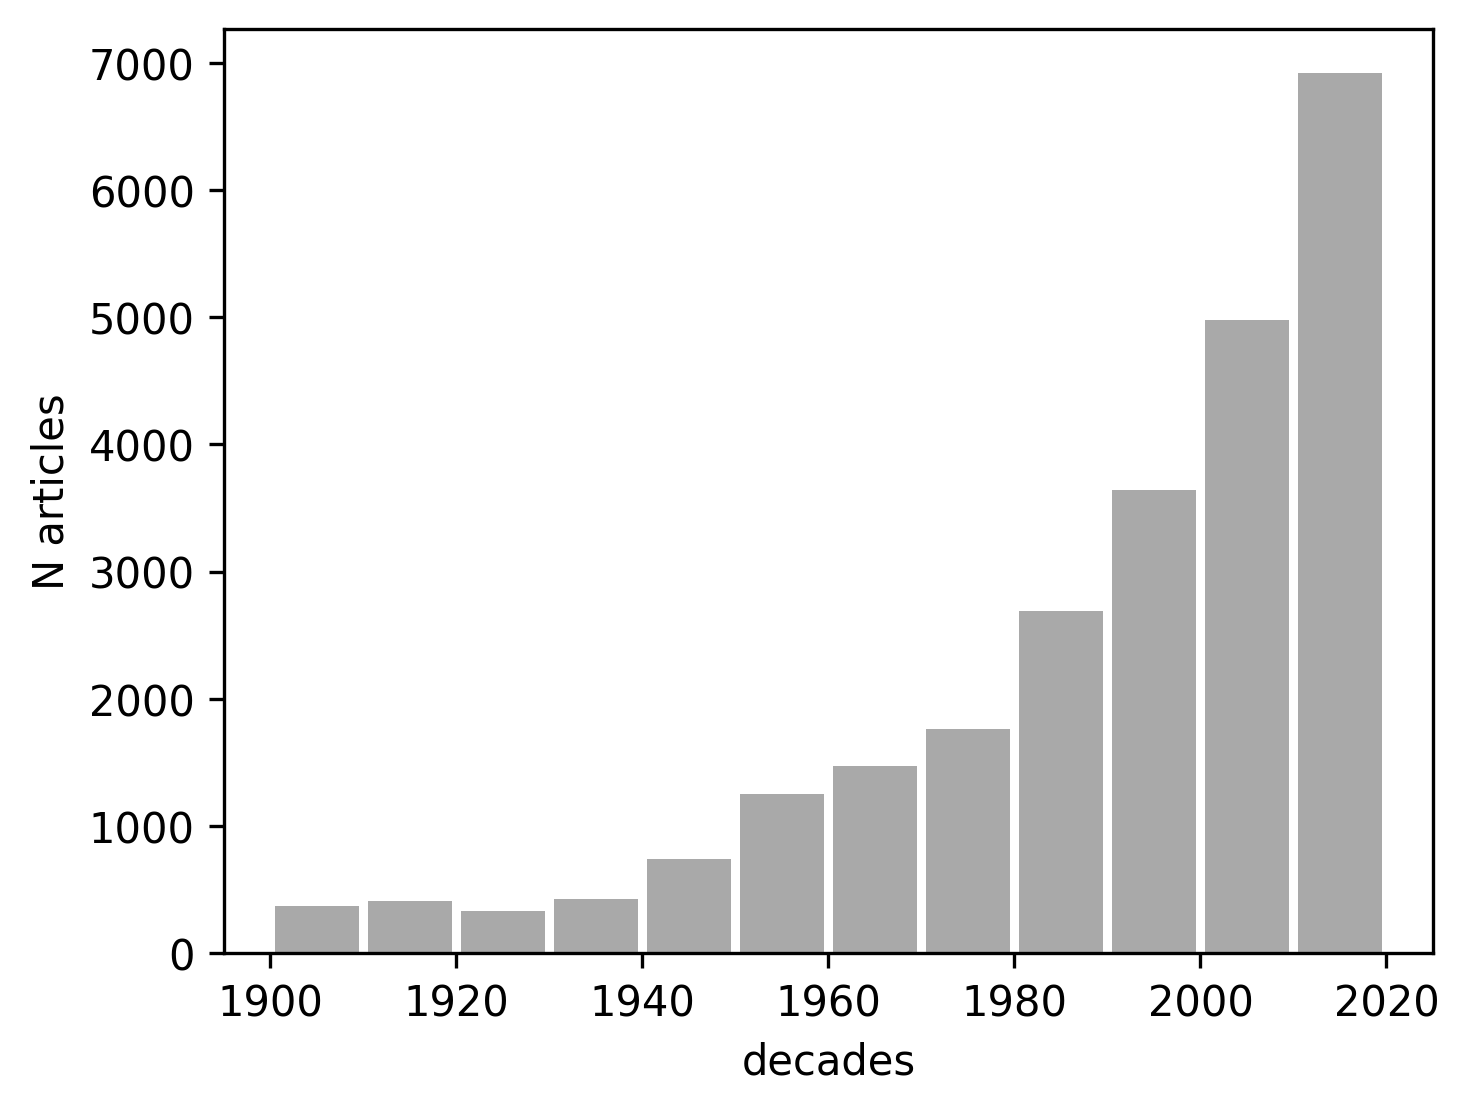

In [25]:
fig, ax = plt.subplots(figsize=(5.2,4), dpi=300)
ax.hist(metadata_df["decade"], bins=decades, rwidth=0.9, color="darkgrey")
ax.set_xlim(1895,2025)
ax.set_ylabel("N articles")
ax.set_xlabel("decades")
#ax.set_xticks([dec+5 for dec in decades])

In [67]:
fig.savefig("../figures/hist_decades_articles.png")

In [35]:
metadata_per_decade = metadata_df.groupby("decade").sum().reset_index()[["decade", "pageCount", "wordCount"]]
metadata_per_decade

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_3092/3353733099.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metadata_per_decade = metadata_df.groupby("decade").sum().reset_index()[["decade", "pageCount", "wordCount"]]


,decade,pageCount,wordCount
0,1870,30,10545
1,1890,2,1420
2,1900,6148,2750899
3,1910,5715,2427625
4,1920,6609,2631921
5,1930,6753,2849278
6,1940,8092,3804267
7,1950,17029,8161368
8,1960,18895,9080522
9,1970,21382,10641341


In [67]:
metadata_df.groupby("bidecade").size().tolist()

[782, 758, 1990, 3234, 6335, 11489]

In [72]:
metadata_per_bidecade = metadata_df.groupby("bidecade").sum().reset_index()
metadata_per_bidecade["articles_N"] = metadata_df.groupby("bidecade").size().tolist()
metadata_per_bidecade = metadata_per_bidecade[["bidecade", "articles_N", "pageCount", "wordCount"]]
metadata_per_bidecade

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_3092/4115257019.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metadata_per_bidecade = metadata_df.groupby("bidecade").sum().reset_index()


,bidecade,articles_N,pageCount,wordCount
0,1900-1919,782,11863,5178524
1,1920-1939,758,13362,5481199
2,1940-1959,1990,25121,11965635
3,1960-1979,3234,40277,19721863
4,1980-1999,6335,90883,46442633
5,2000-2019,11489,242346,139359545


In [27]:
matplotlib.rcParams['axes.formatter.useoffset'] = False

Text(0.5, 0, 'decades')

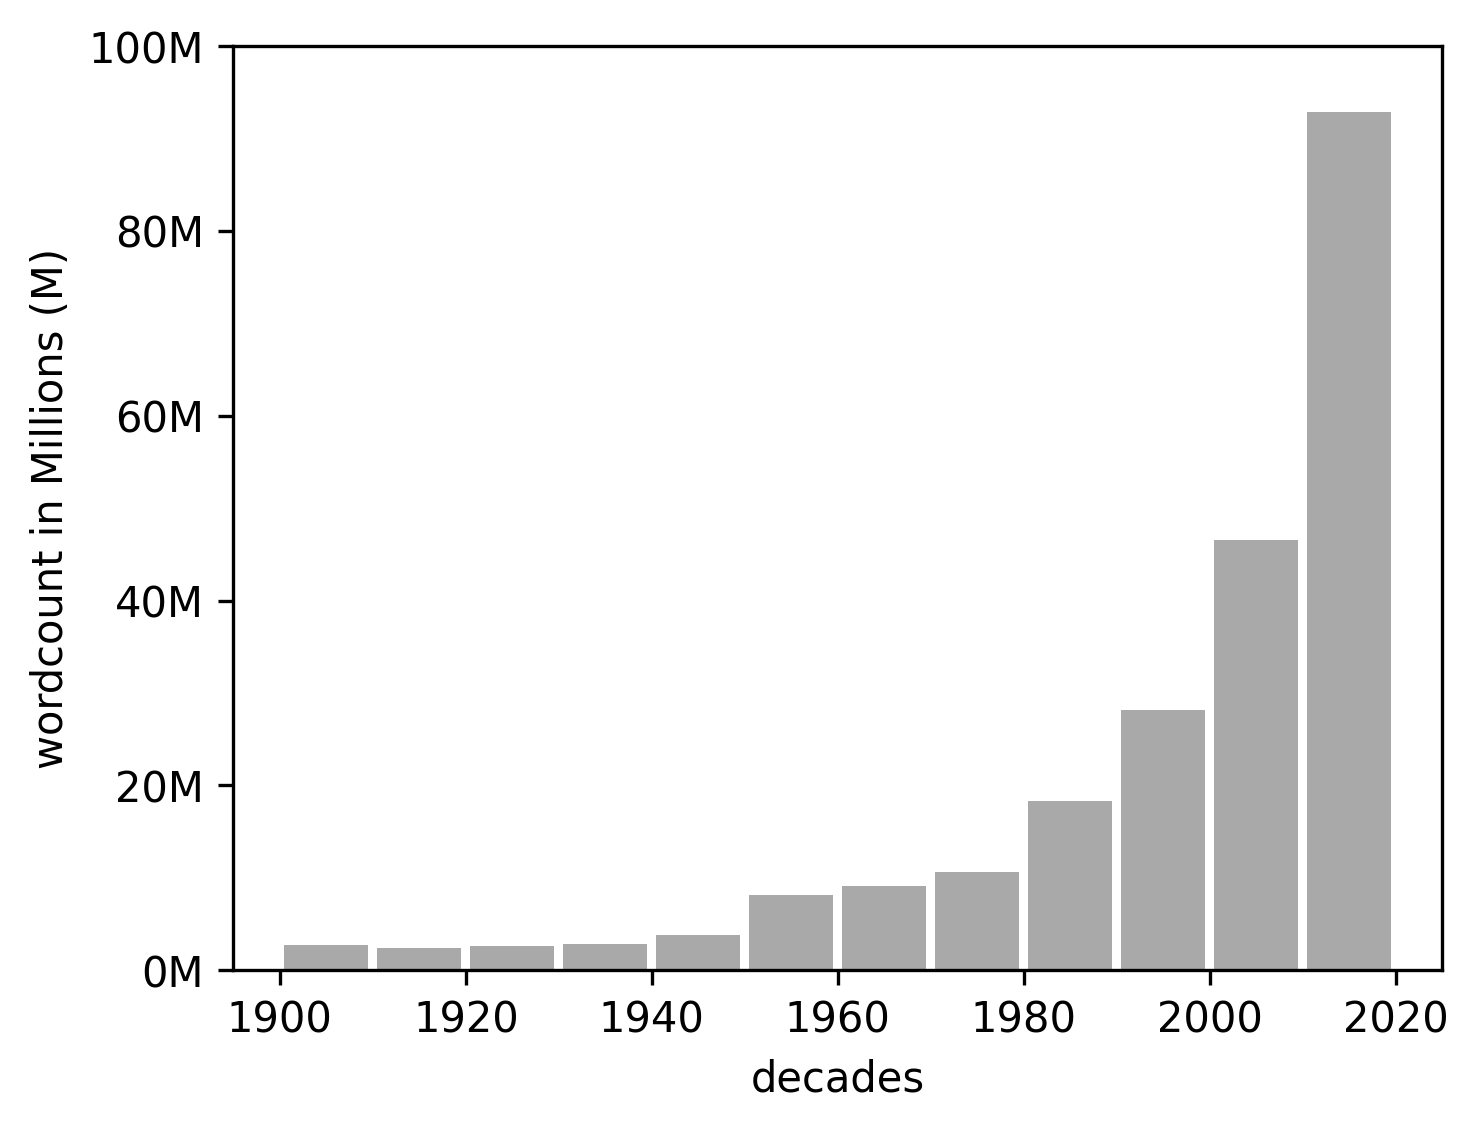

In [28]:
fig, ax = plt.subplots(figsize=(5.2,4), dpi=300)
ax.bar([n+5 for n in metadata_per_decade["decade"]][:-1], metadata_per_decade["wordCount"][:-1], width=9, color="darkgrey")
#ax.set_yticklabels(ax.get_yticks())
#ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlim(1895,2025)
ax.set_yticks(range(0, 120000000, 20000000))
ax.set_yticklabels([str(n)+"M" for n in range(0, 120, 20)])
ax.set_ylabel("wordcount in Millions (M)")
ax.set_xlabel("decades")

In [71]:
fig.savefig("../figures/hist_decades_wordcounts.png")

Text(0.5, 0, 'decades')

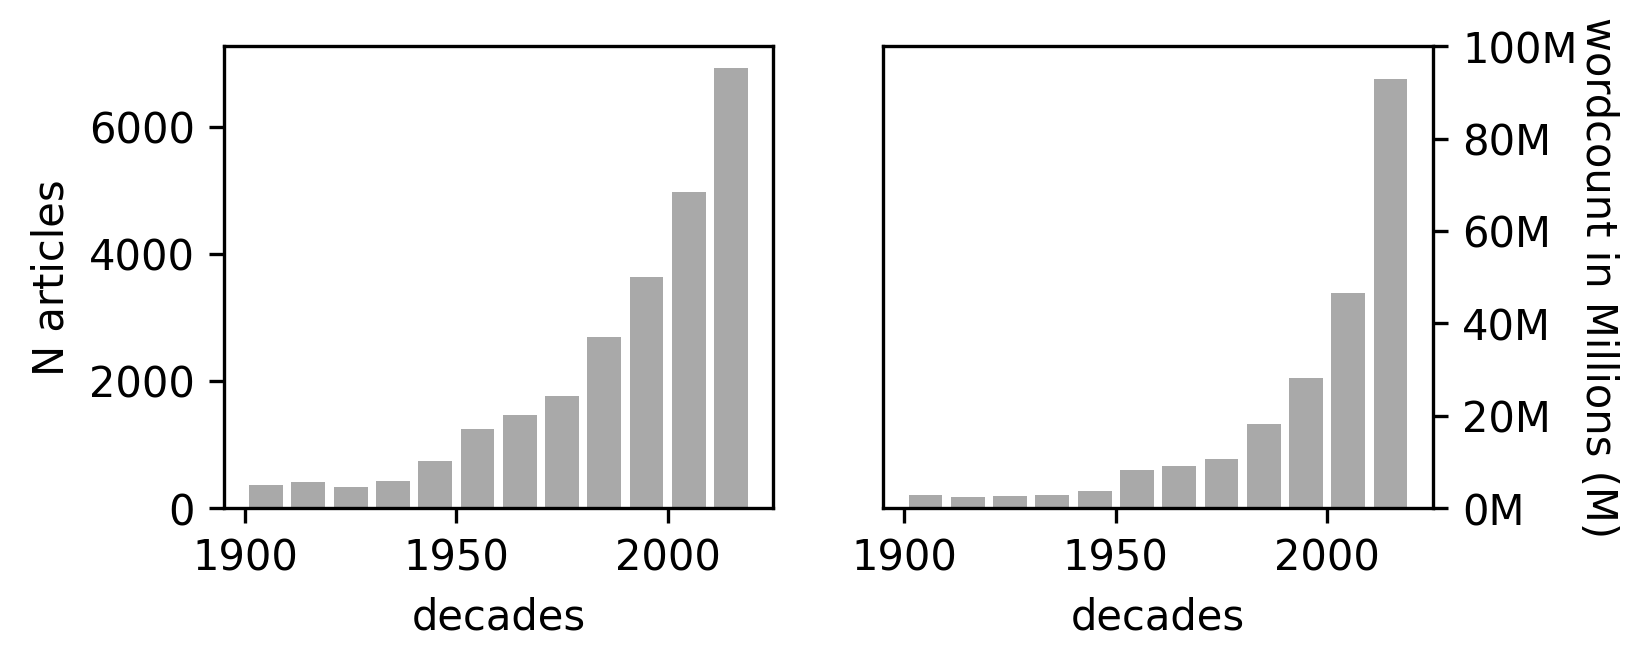

In [29]:

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(5.2,2), dpi=300)
ax1.hist(metadata_df["decade"], bins=decades, rwidth=0.8, color="darkgrey")
ax1.set_xlim(1895,2025)
ax1.set_ylabel("N articles")
ax1.set_xlabel("decades")

ax2.bar([n+5 for n in metadata_per_decade["decade"]][:-1], metadata_per_decade["wordCount"][:-1], width=8, color="darkgrey")
#ax.set_yticklabels(ax.get_yticks())
#ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.set_xlim(1895,2025)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_yticks(range(0, 120000000, 20000000))
ax2.set_yticklabels([str(n)+"M" for n in range(0, 120, 20)])
ax2.set_ylabel("wordcount in Millions (M)", rotation=270, labelpad=10)
ax2.set_xlabel("decades")
#ax.set_xticks([dec+5 for dec in decades])

In [73]:
metadata_per_bidecade

,bidecade,articles_N,pageCount,wordCount
0,1900-1919,782,11863,5178524
1,1920-1939,758,13362,5481199
2,1940-1959,1990,25121,11965635
3,1960-1979,3234,40277,19721863
4,1980-1999,6335,90883,46442633
5,2000-2019,11489,242346,139359545


Text(0.5, 0, 'bidecade')

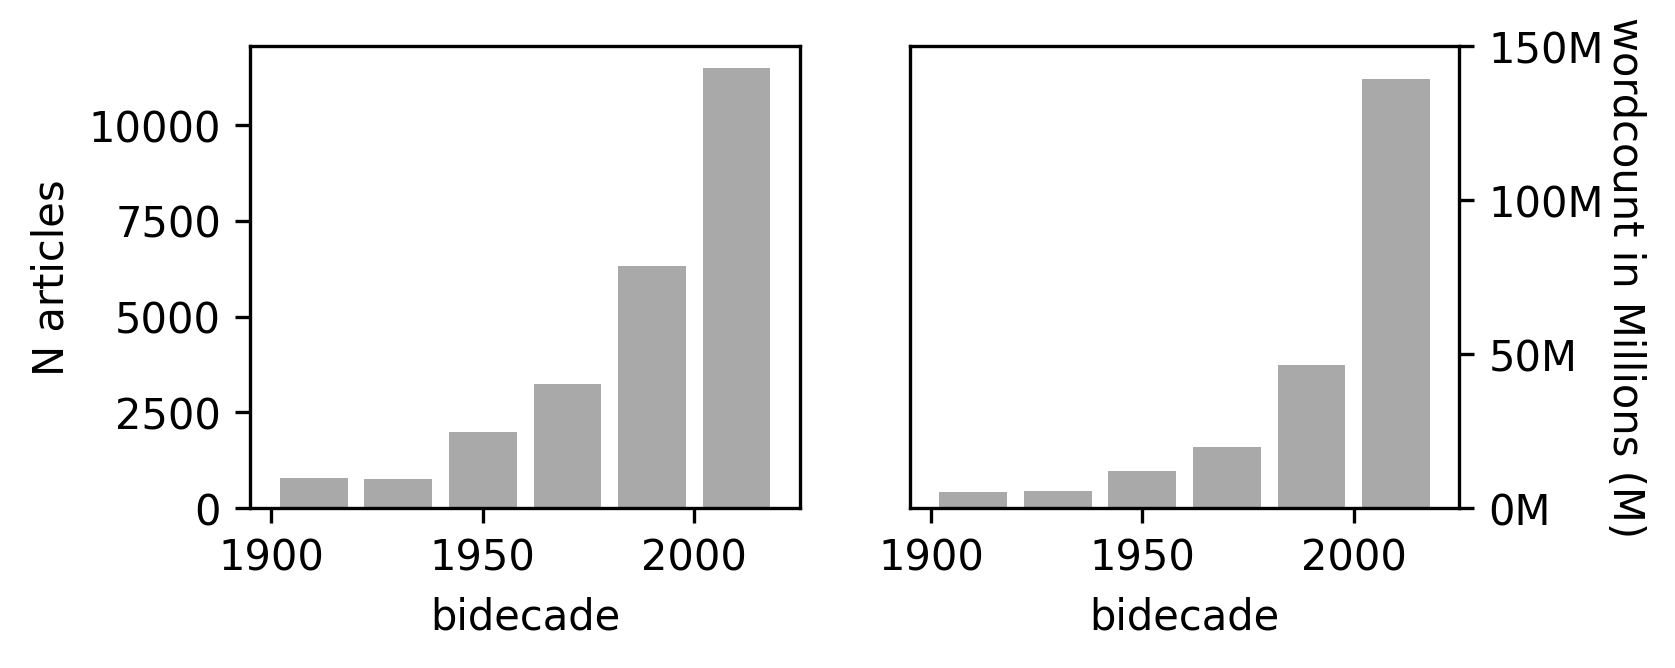

In [77]:

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(5.2,2), dpi=300)
ax1.bar([int(n[:4])+10 for n in metadata_per_bidecade["bidecade"]], metadata_per_bidecade["articles_N"], width=16, color="darkgrey")
ax1.set_xlim(1895,2025)
ax1.set_ylabel("N articles")
ax1.set_xlabel("bidecade")

ax2.bar([int(n[:4])+10 for n in metadata_per_bidecade["bidecade"]], metadata_per_bidecade["wordCount"], width=16, color="darkgrey")
#ax.set_yticklabels(ax.get_yticks())
#ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.set_xlim(1895,2025)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_yticks(range(0, 200000000, 50000000))
ax2.set_yticklabels([str(n)+"M" for n in range(0, 200, 50)])
ax2.set_ylabel("wordcount in Millions (M)", rotation=270, labelpad=10)
ax2.set_xlabel("bidecade")
#ax.set_xticks([dec+5 for dec in decades])

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_3092/2747721919.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([int(n) for n in ax.get_xticks()], color="white")
/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_3092/2747721919.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([int(n) for n in ax1.get_yticks()], color="white")
/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_3092/2747721919.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([int(n) for n in ax.get_xticks()], color="white")


Text(0.5, 0, 'decades')

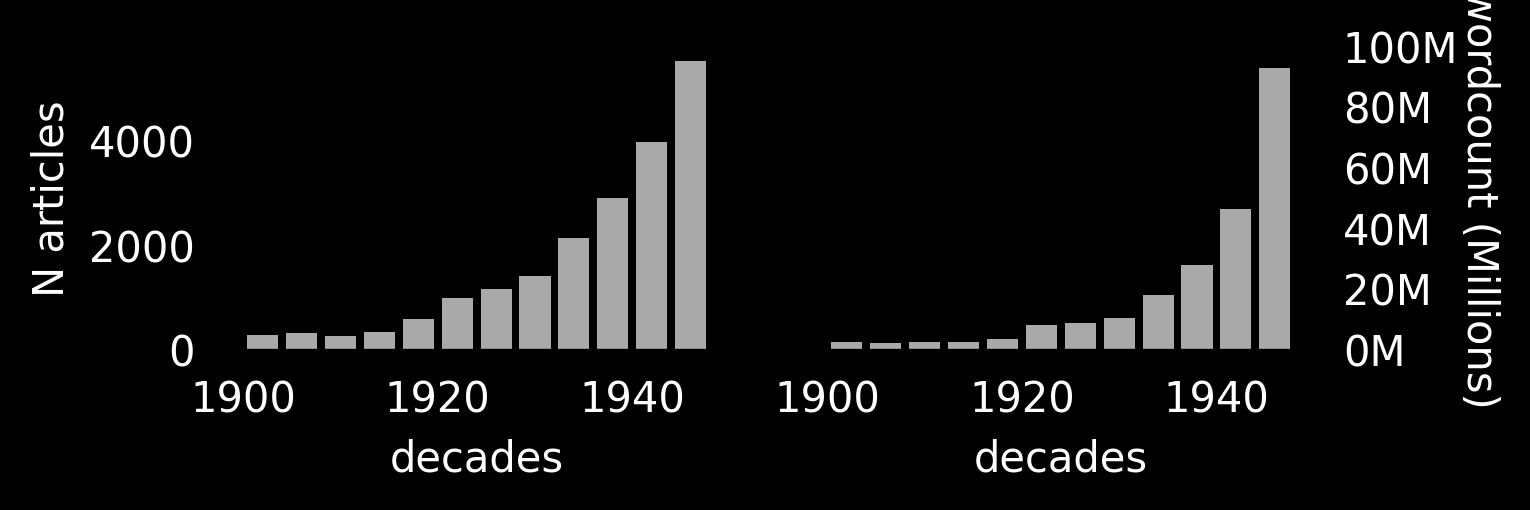

In [30]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(5.2,1.8), dpi=300, tight_layout=True)
fig.patch.set_facecolor("black")
ax1.set_facecolor("black")
ax1.hist(metadata_df["decade"], bins=decades, rwidth=0.8, color="darkgrey")
ax1.set_xlim(1895,2025)
ax1.set_xticklabels([int(n) for n in ax.get_xticks()], color="white")
ax1.set_yticklabels([int(n) for n in ax1.get_yticks()], color="white")
ax1.set_ylabel("N articles", color="white")
ax1.set_xlabel("decades", color="white")


ax2.set_facecolor("black")
ax2.bar([n+5 for n in metadata_per_decade["decade"]][:-1], metadata_per_decade["wordCount"][:-1], width=8, color="darkgrey")
#ax.set_yticklabels(ax.get_yticks())
#ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.set_xlim(1895,2025)
ax2.set_xticklabels([int(n) for n in ax.get_xticks()], color="white")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_yticks(range(0, 120000000, 20000000))
ax2.set_yticklabels([str(n)+"M" for n in range(0, 120, 20)], color="white")
ax2.set_ylabel("wordcount (Millions)", rotation=270, labelpad=10, color="white")
ax2.set_xlabel("decades", color="white")
#ax.set_xticks([dec+5 for dec in decades])

In [95]:
fig.savefig("../figures/overview_decades.png")

In [44]:
metadata_df.groupby("decade").mean()

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_38336/3331929625.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metadata_df.groupby("decade").mean()


,pageCount,publicationYear,sequence,wordCount,id_kase,year
decade,,,,,,
1870,15.000000,1908.000000,46.000000,5272.500000,15335.500000,1873.000000
1890,2.000000,1959.000000,41.000000,1420.000000,18637.000000,1895.000000
1900,16.571429,1904.617251,8.428571,7414.822102,14276.067385,1904.617251
1910,13.905109,1914.072993,7.686275,5906.630170,14246.476886,1914.072993
1920,19.846847,1926.411411,10.392857,7903.666667,13607.234234,1924.777778
1930,15.889412,1934.976471,9.045455,6704.183529,13914.390588,1934.976471
1940,10.920378,1945.122807,13.288288,5133.963563,13122.574899,1945.122807
1950,13.634107,1954.490793,12.565287,6534.321857,12416.522818,1954.490793
1960,12.862491,1964.594282,11.463245,6181.430905,12564.962560,1964.594282


In [45]:
metadata_df[mask_articles].groupby("decade").mean()

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_38336/515994493.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metadata_df[mask_articles].groupby("decade").mean()


,pageCount,publicationYear,sequence,wordCount,id_kase,year
decade,,,,,,
1870,13.000000,1908.000000,66.000000,4546.000000,19641.000000,1873.000000
1900,21.310881,1904.823834,4.333333,9526.663212,14337.326425,1904.823834
1910,17.303030,1913.939394,4.600000,7239.627706,14924.913420,1913.939394
1920,25.363158,1926.247368,6.454545,9748.189474,14656.663158,1924.668421
1930,24.866667,1934.466667,4.000000,10342.630769,14702.928205,1934.466667
1940,16.016287,1945.026059,4.804878,7364.042345,14900.605863,1945.026059
1950,23.260341,1954.399027,4.207547,10990.467153,14276.939173,1954.399027
1960,21.951904,1964.883768,5.541667,10428.490982,14185.048096,1964.883768
1970,18.143541,1975.020734,5.576471,8991.231260,13824.283892,1975.020734


# Individual text exploration

In [46]:
metadata_df[metadata_df["isPartOf"]=="New Testament Studies"].sort_values("year", ascending=False)

,creator,datePublished,docType,doi,id,identifier,isPartOf,issueNumber,keyphrase,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sequence,tdmCategory,title,url,volumeNumber,wordCount,id_kase,docSubType,sourceCategory,abstract,subTitle,year,decade,bidecade
16174,[Christopher S. Atkins],2021-10-01,article,10.1017/S0028688521000114,ark://27927/phzqbgq970t,"[{'name': 'local_publisher_id', 'value': 'S002...",New Testament Studies,4,None,[eng],"[unigram, bigram, trigram]",15,612,598,598-612,portico,2021,Cambridge University Press,9.0,"[Religion - Theology, History - Historical met...",The Justice of the Cosmos: Philosophical Cosmo...,http://doi.org/10.1017/S0028688521000114,67,7971,16174,research-article,None,None,None,2021,2020,None
6075,[Michael Dormandy],2021-04-01,article,10.1017/S0028688520000260,ark://27927/phzm9xhzxwz,"[{'name': 'local_publisher_id', 'value': 'S002...",New Testament Studies,2,None,[eng],"[unigram, bigram, trigram]",21,240,220,220-240,portico,2021,Cambridge University Press,6.0,[Religion - Theology],How to Understand What Passes All Understandin...,http://doi.org/10.1017/S0028688520000260,67,9336,6075,research-article,None,None,None,2021,2020,None
12910,[Benjamin A. Edsall],2021-07-01,article,10.1017/S0028688521000047,ark://27927/phzp3sf77h8,"[{'name': 'local_publisher_id', 'value': 'S002...",New Testament Studies,3,None,[eng],"[unigram, bigram, trigram]",17,423,407,407-423,portico,2021,Cambridge University Press,7.0,[Religion - Theology],Aphrahat and Pauline Reception: 1 Corinthians ...,http://doi.org/10.1017/S0028688521000047,67,8841,12910,research-article,None,None,None,2021,2020,None
10158,[Joseph Longarino],2021-10-01,article,10.1017/S0028688521000060,ark://27927/phzqbgq968q,"[{'name': 'local_publisher_id', 'value': 'S002...",New Testament Studies,4,None,[eng],"[unigram, bigram, trigram]",16,597,582,582-597,portico,2021,Cambridge University Press,8.0,[Philosophy - Applied philosophy],Apocalyptic and the Passions: Overcoming a Fal...,http://doi.org/10.1017/S0028688521000060,67,8823,10158,research-article,None,None,None,2021,2020,None
1967,[Candida Moss],2021-04-01,article,10.1017/S0028688520000351,ark://27927/phzm9xj00kz,"[{'name': 'local_publisher_id', 'value': 'S002...",New Testament Studies,2,None,[eng],"[unigram, bigram, trigram]",24,204,181,181-204,portico,2021,Cambridge University Press,4.0,"[Arts - Literature, Religion - Theology]",Fashioning Mark: Early Christian Discussions a...,http://doi.org/10.1017/S0028688520000351,67,12474,1967,research-article,None,None,None,2021,2020,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,[Leon Morris],1955-09-01,article,10.1017/S0028688500017197,ark://27927/pgh1gc61bxr,"[{'name': 'local_publisher_id', 'value': 'S002...",New Testament Studies,1,"[mercy seat, romans, atonement, propitiatory, ...",[eng],"[unigram, bigram, trigram]",11,43,33,33-43,portico,1955,Cambridge University Press,5.0,[History - Historical methodology],The Meaning of 'Iithpion in Romans iii. 25,http://doi.org/10.1017/S0028688500017197,2,5911,8842,None,None,None,None,1955,1950,1940-1959
9159,[Richard Heard],1954-11-01,article,10.1017/S0028688500003635,ark://27927/pgh1gc4wn4w,"[{'name': 'local_publisher_id', 'value': 'S002...",New Testament Studies,2,"[papias, irenaeus, gospel, justins, apostles, ...",[eng],"[unigram, bigram, trigram]",8,129,122,122-129,portico,1954,Cambridge University Press,6.0,"[Religion - Spiritual belief systems, Religion...","(A) The Aφomnhmoneymata in Papias, Justin, and...",http://doi.org/10.1017/S0028688500003635,1,4026,9159,None,None,None,None,1954,1950,1940-1959
23420,[J. Andrew Cowan],1921-01-01,article,10.1017/S0028688520000223,ark://27927/phzjm9743rf,"[{'name': 'local_publisher_id', 'value': 'S002...",New Testament Studies,1,"[socrates, areopagus speech, euthyphro, gärtne...",[eng],"[unigram, bigram, trigram]",13,133,121,121-133

In [47]:
article_id = 1203 # id for "Paul the Cosmopolitan?"

In [48]:
with open("../data/large_files/trigrams_raw/trigrams_{}.json".format(str(article_id)), "r") as f:
    trigrams_json = json.load(f)

In [50]:
trigrams_most_freq_example = pd.DataFrame(sorted(trigrams_json.items(), key=lambda x: x[1], reverse=True)[:50], columns=["trigram", "count"])
trigrams_most_freq_example

,trigram,count
0,Paul the Cosmopolitan?,11
1,TOPHER D .,9
2,D . S,9
3,. S TANLEY,9
4,I S TOPHER,9
5,S TOPHER D,9
6,CHR I S,9
7,For more on,8
8,"Delanty, Cosmopolitan Imagination,",7
9,would have been,7


In [62]:
google_conf.set_with_dataframe(mops_data.add_worksheet("trigrams_most_freq_example", 1,1), trigrams_most_freq_example)

In [ ]:
with open("../data/large_files/unigrams_raw/trigrams_{}.json".format(str(article_id)), "r") as f:
    trigrams_json = json.load(f)

In [18]:
unigramCount_dict = pickle.load(open("../data/large_files/unigramCount_dict.pickle", "rb"))

In [49]:
# manual test
col = "publicationYear"
matchstring = "==1951"
eval('metadata_df[metadata_df["{0}"]{1}]'.format(col, matchstring))["id"].tolist()

['http://www.jstor.org/stable/1198957',
 'http://www.jstor.org/stable/1508417',
 'ark://27927/phx7f9rxk2',
 'http://www.jstor.org/stable/3261590',
 'http://www.jstor.org/stable/24456097',
 'ark://27927/pgg389199fd',
 'ark://27927/phx61xr9tmg',
 'ark://27927/pgh1g2mt8q5',
 'ark://27927/phx61xrbpxv',
 'ark://27927/phx64dprn08',
 'http://www.jstor.org/stable/43720276',
 'http://www.jstor.org/stable/20516383',
 'http://www.jstor.org/stable/41175585',
 'ark://27927/phx61tbjnvh',
 'http://www.jstor.org/stable/1198933',
 'http://www.jstor.org/stable/1456587',
 'http://www.jstor.org/stable/43720275',
 'http://www.jstor.org/stable/44210186',
 'ark://27927/phx622zp8bt',
 'http://www.jstor.org/stable/1197811',
 'ark://27927/pgh1h1tfc4p',
 'http://www.jstor.org/stable/42621087',
 'ark://27927/phx61tbjqw3',
 'ark://27927/phx64dprn74',
 'ark://27927/pgh1h00bn1j',
 'ark://27927/pgh1g2mt8xg',
 'ark://27927/phx6bfsx4f4',
 'http://www.jstor.org/stable/1198956',
 'http://www.jstor.org/stable/3262039',
 '

In [19]:
def ids_from_colvals(col, matchstring):
    ids = eval('metadata_df[metadata_df["{0}"]{1}]'.format(col, matchstring))["id"].tolist()
    return ids

In [20]:
# test with function...
len(ids_from_colvals("publicationYear", ".between(1950, 1959)"))

403

In [21]:
test_ids = ids_from_colvals("publicationYear", "==1951")
len(test_ids)

37

In [22]:
unigramCount_dict[test_ids[0]]

{'NEIL.': 1,
 'assumption.': 1,
 'emphases': 1,
 'work': 2,
 "Neil's": 1,
 "man's": 1,
 'by-passed.': 1,
 'apply': 1,
 'others,': 1,
 'home.': 1,
 'or,': 1,
 'Acts.': 1,
 'pages': 1,
 'has': 2,
 'discus-': 1,
 'connection': 2,
 '"ten-': 1,
 'scanty': 1,
 'amid': 1,
 'treat-': 1,
 'mis-': 1,
 'Lord': 1,
 'II': 3,
 'on': 11,
 'One': 1,
 'writings.': 1,
 'indorse': 1,
 'dis-': 1,
 'text': 3,
 'intentions': 1,
 'Many': 1,
 'however,': 1,
 'insights': 1,
 'ac-': 1,
 'Sermon': 2,
 'of': 98,
 'xlv).': 1,
 'disagree-': 1,
 'Bros.,': 1,
 'Christians': 1,
 'authorities': 1,
 'eschatology.': 2,
 '79,': 1,
 '"restraining': 1,
 'charge': 1,
 'sion': 1,
 'will': 3,
 'so': 1,
 'modernizing': 1,
 'level': 1,
 'defined': 1,
 'blasphemous': 1,
 'epistles,': 1,
 '21,': 1,
 'York:': 2,
 'enemies': 2,
 'instance,': 1,
 'Introduction': 1,
 'reality': 2,
 'tion': 3,
 'treatment': 1,
 'adequate': 1,
 'indorses': 1,
 'Christianity.': 1,
 'data': 2,
 'interesting': 2,
 'series,': 1,
 'supposed': 1,
 'Account': 

In [64]:
c = Counter()
for id in test_ids:
    d = unigramCount_dict[id]
    print(len(d))
    c.update(d)

862
531
1250
1450
2219
1152
2181
1581
2134
2872
1247
1135
1255
1727
733
1218
4749
1875
1590
2344
2139
3184
2348
1404
2572
939
2297
799
2624
2775
1019
1914
1747
1284
1365
2629
519


In [69]:
def merge_data_from_ids(ids, datadict):
    c = Counter()
    for id in ids:
        d = datadict[id]
        c.update(d)
    return c

In [67]:
sorted(c.items(), key=lambda kv: kv[1], reverse=True)

[('the', 13802),
 ('of', 9030),
 ('and', 5024),
 ('to', 4495),
 ('in', 4398),
 ('is', 2709),
 ('a', 2576),
 ('that', 2244),
 ('as', 1425),
 ('The', 1367),
 ('for', 1293),
 ('his', 1261),
 ('which', 1239),
 ('be', 1180),
 ('was', 1162),
 ('not', 1148),
 ('he', 1101),
 ('by', 1057),
 ('it', 971),
 ('with', 968),
 ('this', 836),
 ('from', 818),
 ('on', 727),
 ('are', 726),
 ('have', 669),
 ('but', 648),
 ('.', 621),
 ('we', 600),
 ('who', 586),
 ('or', 539),
 ('had', 539),
 ('at', 538),
 ('has', 537),
 ('their', 497),
 ('an', 485),
 ('were', 479),
 ('one', 455),
 ('all', 446),
 ('they', 439),
 ('Paul', 409),
 ('God', 404),
 ('I', 396),
 ('its', 391),
 ('been', 390),
 ('In', 371),
 ('no', 368),
 ('It', 357),
 ('Testament', 339),
 ('will', 331),
 ('our', 331),
 ('Christian', 331),
 ('only', 313),
 ('would', 297),
 ('can', 282),
 ('New', 281),
 ('there', 279),
 ('more', 279),
 ('Old', 279),
 ('so', 277),
 ('into', 264),
 ('p.', 260),
 ('other', 258),
 ('must', 258),
 ('He', 256),
 ('Jesus', 

In [73]:
#english stopwords...
sp = spacy.load('en_core_web_sm')
stop_words = sp.Defaults.stop_words

In [74]:
type(stop_words)

set

In [109]:
def get_tops(col, matchstring, n=10):
    ids = ids_from_colvals(col, matchstring)
    c = merge_data_from_ids(ids, unigramCount_dict)
    c_tups = [el for el in c.items() if el[0].lower() not in list(stop_words) + [".", "-", "\""]]
    top10 = sorted(c_tups, key=lambda kv: kv[1], reverse=True)[:n]
    return top10

In [110]:
get_tops("publicationYear", "==1951", 20)

[('Paul', 409),
 ('God', 404),
 ('Testament', 339),
 ('Christian', 331),
 ('New', 281),
 ('Old', 279),
 ('p.', 260),
 ('Jesus', 248),
 ('man', 238),
 ('Christ', 237),
 ('Gospel', 233),
 ('life', 225),
 ('law', 208),
 ('love', 192),
 ('new', 173),
 ('Church', 170),
 ('St.', 168),
 (';', 167),
 ('men', 161),
 ("God's", 156)]

In [111]:
get_tops("publicationYear", ".between(1950,1959)")

[('God', 5002),
 ('Paul', 3773),
 ('Christian', 3543),
 ('Christ', 3098),
 ('New', 2981),
 ('Church', 2966),
 ('Jesus', 2862),
 ('p.', 2506),
 ('life', 2377),
 ('St.', 2364)]

In [112]:
for decade_n in range(0,10):
    print("19{0}0,19{0}9".format(str(decade_n)))

1900,1909
1910,1919
1920,1929
1930,1939
1940,1949
1950,1959
1960,1969
1970,1979
1980,1989
1990,1999


In [113]:
for decade_n in range(0,10):
    decade = "19{0}0,19{0}9".format(str(decade_n))
    print(decade, get_tops("publicationYear", ".between({0})".format(decade), 20))


1900,1909 [('Proc.', 3172), ('d.', 2347), (':', 2342), ('2', 2219), ('de', 2113), ('Jesus', 2013), ('u.', 1737), ('&', 1650), ('God', 1647), ('New', 1622), ('Christian', 1493), ('der', 1478), ('Paul', 1440), ('3', 1371), ('des', 1366), ('Testament', 1330), ('Christ', 1290), ('?', 1251), ('et', 1209), ('1', 1179)]
1910,1919 [('Jesus', 1776), ('God', 1736), ('Christian', 1542), ('great', 1405), ('church', 1200), ('life', 1182), ('time', 1177), ('p.', 1171), ('man', 1128), ('Paul', 1126), ('New', 1096), ('religious', 950), ('Christ', 905), ('men', 893), ('shall', 878), ('?', 858), (';', 845), ('found', 812), ('new', 794), ('work', 787)]
1920,1929 [('|', 7527), ('p.', 2363), ('pp.', 1682), ('New', 1568), (':', 1110), ('Christian', 1054), ('1', 900), ('work', 871), ('Paul', 852), ('St.', 845), (';', 811), ('great', 788), ('time', 764), ('God', 754), ('religious', 725), ('A.', 702), ('Jewish', 692), ('American', 683), ("'", 635), ('new', 629)]
1930,1939 [('et', 2512), ('p.', 1790), ('God', 1

In [102]:
bigramCount_dict = pickle.load(open("../data/large_files/bigramCount_dict.pickle", "rb"))

In [107]:
def get_top_bigrams(col, matchstring, n=10):
    ids = ids_from_colvals(col, matchstring)
    c = merge_data_from_ids(ids, bigramCount_dict)
    #c_tups = [el for el in c.items() if el[0].lower() not in list(stop_words)]
    tops = sorted(c.items(), key=lambda kv: kv[1], reverse=True)[:n]
    return tops

In [108]:
for decade_n in range(0,10):
    decade = "19{0}0,19{0}9".format(str(decade_n))
    print(decade, get_top_bigrams("publicationYear", ".between({0})".format(decade), 10))

1900,1909 [('of the', 21104), ('in the', 8596), ('to the', 5662), ('and the', 3227), ('- -', 3015), ('. .', 2882), ('that the', 2608), ('on the', 2244), ('by the', 2183), ('to be', 2122)]
1910,1919 [('of the', 18350), ('in the', 8101), ('to the', 5355), ('and the', 3300), ('that the', 2540), ('. .', 2416), ('on the', 2058), ('to be', 2054), ('from the', 2042), ('with the', 1988)]
1920,1929 [('of the', 13452), ('in the', 5457), ('. .', 4018), ('to the', 3686), ('and the', 2241), ('on the', 1742), ('for the', 1564), ('with the', 1452), ('from the', 1426), ('by the', 1419)]
1930,1939 [('of the', 13587), ('in the', 5959), ('to the', 4491), ('and the', 2441), ('that the', 1689), ('for the', 1599), ('by the', 1516), ('to be', 1460), ('with the', 1453), ('on the', 1420)]
1940,1949 [('of the', 21661), ('in the', 9715), ('to the', 6489), ('and the', 3567), ('that the', 3104), ('to be', 2730), ('on the', 2425), ('for the', 2410), ('with the', 2384), ('by the', 2219)]
1950,1959 [('of the', 37166)